<a href="https://colab.research.google.com/github/yadavrishikesh/BayesNF/blob/main/BayesNF_on_EcoCounter_bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
!pip install -q bayesnf

In [82]:
!pip -q install cartopy
!pip -q install contextily
!pip -q install geopandas

In [83]:
import warnings
warnings.simplefilter('ignore')

import contextily as ctx
import geopandas as gpd
import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cartopy import crs as ccrs
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [84]:
!wget -q https://raw.githubusercontent.com/yadavrishikesh/BayesNF/main/data/train_data_Eco_pred-type_spatIntpl.csv
df_train = pd.read_csv('train_data_Eco_pred-type_spatIntpl.csv', index_col=0, parse_dates=['datetime'])


In [85]:
df_train.head(10)

,datetime,elev,walkscore,num_ppo,temp,precp,visbl,wsp,lon,lat,response
8,2022-04-22,-0.579066,-0.533333,-0.021161,-0.691037,-0.070925,-0.126790,0.406899,-73.544426,45.530216,494
9,2022-04-23,-0.579066,-0.533333,-0.021161,-0.971799,-0.070925,0.487823,-0.360644,-73.544426,45.530216,677
10,2022-04-24,-0.579066,-0.533333,-0.021161,-0.796038,-0.070925,0.276179,0.508880,-73.544426,45.530216,474
11,2022-04-25,-0.579066,-0.533333,-0.021161,-0.218916,-0.070925,-0.331661,0.498145,-73.544426,45.530216,604
12,2022-04-26,-0.579066,-0.533333,-0.021161,-0.355112,-0.020347,-0.597486,0.261978,-73.544426,45.530216,620
13,2022-04-27,-0.579066,-0.533333,-0.021161,-1.025440,0.186361,-1.431362,0.420317,-73.544426,45.530216,198
14,2022-04-28,-0.579066,-0.533333,-0.021161,-0.989299,-0.070925,0.487823,0.490094,-73.544426,45.530216,743
15,2022-04-29,-0.579066,-0.533333,-0.021161,-0.778537,-0.070925,0.692694,0.310285,-73.544426,45.530216,720
16,2022-04-30,-0.579066,-0.533333,-0.021161,-0.603917,-0.066527,0.590258,-0.215723,-73.544426,45.530216,1056
17,2022-05-01,-0.579066,-0.533333,-0.021161,-0.323917,-0.070925,0.795129,-0.282816,-73.544426,45.530216,1387


In [86]:
df_train_log= df_train.copy()
df_train_log['response'] = np.log1p(df_train_log['response'])

In [87]:
df_train_log.head(10)

,datetime,elev,walkscore,num_ppo,temp,precp,visbl,wsp,lon,lat,response
8,2022-04-22,-0.579066,-0.533333,-0.021161,-0.691037,-0.070925,-0.126790,0.406899,-73.544426,45.530216,6.204558
9,2022-04-23,-0.579066,-0.533333,-0.021161,-0.971799,-0.070925,0.487823,-0.360644,-73.544426,45.530216,6.519147
10,2022-04-24,-0.579066,-0.533333,-0.021161,-0.796038,-0.070925,0.276179,0.508880,-73.544426,45.530216,6.163315
11,2022-04-25,-0.579066,-0.533333,-0.021161,-0.218916,-0.070925,-0.331661,0.498145,-73.544426,45.530216,6.405228
12,2022-04-26,-0.579066,-0.533333,-0.021161,-0.355112,-0.020347,-0.597486,0.261978,-73.544426,45.530216,6.431331
13,2022-04-27,-0.579066,-0.533333,-0.021161,-1.025440,0.186361,-1.431362,0.420317,-73.544426,45.530216,5.293305
14,2022-04-28,-0.579066,-0.533333,-0.021161,-0.989299,-0.070925,0.487823,0.490094,-73.544426,45.530216,6.612041
15,2022-04-29,-0.579066,-0.533333,-0.021161,-0.778537,-0.070925,0.692694,0.310285,-73.544426,45.530216,6.580639
16,2022-04-30,-0.579066,-0.533333,-0.021161,-0.603917,-0.066527,0.590258,-0.215723,-73.544426,45.530216,6.963190
17,2022-05-01,-0.579066,-0.533333,-0.021161,-0.323917,-0.070925,0.795129,-0.282816,-73.544426,45.530216,7.235619


In [88]:
from bayesnf.spatiotemporal import BayesianNeuralFieldMAP

model = BayesianNeuralFieldMAP(
  width=512,
  depth=2,
  freq='D',
  seasonality_periods=['W'], # weekly seasonality
  num_seasonal_harmonics=[2], # 2 harmonics
  feature_cols=['datetime', 'lat', 'lon', 'elev',	'walkscore', 'num_ppo',	'temp',	'precp', 'visbl',	'wsp'], # time, spatial 1, ..., spatial n
  target_col='response',
  observation_model='NORMAL',
  timetype='index'
  )

In [89]:
# Train MAP ensemble
model = model.fit(
    df_train_log, #df_train,
    seed=jax.random.PRNGKey(0),
    ensemble_size=5,
    num_epochs=500,
    )

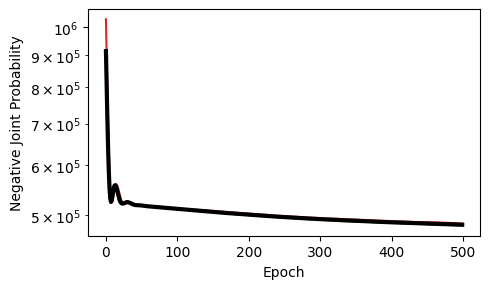

In [91]:
import matplotlib.pyplot as plt
losses = np.row_stack(model.losses_)
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.plot(losses.T)
ax.plot(np.mean(losses, axis=0), color='k', linewidth=3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Negative Joint Probability')
ax.set_yscale('log', base=10)

In [92]:
#!wget -q https://cs.cmu.edu/~fsaad/assets/bayesnf/air_quality.5.test.csv
!wget -q https://raw.githubusercontent.com/yadavrishikesh/BayesNF/main/data/test_data_Eco_pred-type_spatIntpl.csv
df_test = pd.read_csv('test_data_Eco_pred-type_spatIntpl.csv', index_col=0, parse_dates=['datetime'])
df_test.shape




(1075, 11)

In [94]:
# Remove rows with NA values in the 'response' column
df_test_cleaned = df_test.dropna(subset=['response'])
# Verify that there are no more NA values in any column
print(df_test_cleaned.isnull().sum())

df_test_cleaned_log= df_test_cleaned.copy()
df_test_cleaned_log['response']= np.log1p(df_test_cleaned_log['response'])

datetime     0
elev         0
walkscore    0
num_ppo      0
temp         0
precp        0
visbl        0
wsp          0
lon          0
lat          0
response     0
dtype: int64


In [95]:
yhat, yhat_quantiles = model.predict(df_test_cleaned, quantiles=(0.025, 0.5, 0.975))

In [96]:
yhat_quantiles[1].shape

(1032,)

In [97]:
df_test_cleaned.shape

(1032, 11)

Text(0, 0.5, 'Predicted Value')

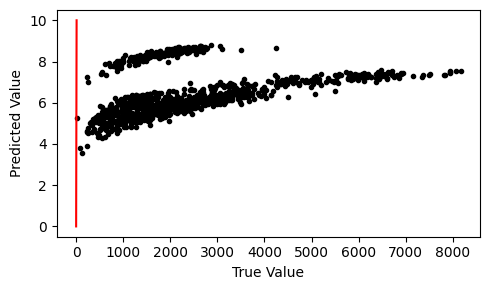

In [99]:
fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
ax.scatter(df_test_cleaned_log.response, yhat_quantiles[1], marker='.', color='k')
ax.plot([0, 10], [0, 10], color='red')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')

In [70]:
predictions_df = pd.DataFrame({'True_Values': df_test_cleaned.response,
                               'Predicted_Values': yhat_quantiles[1]})
predictions_df.head(10)

,True_Values,Predicted_Values
1,2874.0,1029.431274
2,1600.0,988.092163
3,1176.0,990.498108
4,2285.0,1005.359863
5,322.0,959.330200
6,1961.0,992.854309
7,1490.0,1011.973267
8,2937.0,1018.253967
9,3553.0,1006.868225
10,2049.0,1015.905151
